In [7]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [8]:
env = BlackjackEnv()

In [9]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        policy = np.ones(nA) * ( epsilon / float(nA))
        policy[np.max(Q[observation][:])] += 1 - epsilon
    return policy_fn

In [10]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function taht takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    import numpy as np
    for epi_cnt in xrange(num_episodes):
        ## compute Q function
        ## update policy 
        observation = env.reset()
        current_epi = []
        while True:
            action = policy(observation)
            action = np.random.choice(env.nA, 1, p=action)[0]
            next_observation, reward, done, _ = env.step(action)
            current_epi.append((observation, action, reward))
            observation = next_observation
            if done:
                current_epi.reverse()
                accumulated_reward = 0.0
                for state, action, reward  in current_epi:
                    accumulated_reward = reward + discount_factor * accumulated_reward
                    returns_sum[(state, action)] += accumulated_reward
                    returns_count[(state, action)] += 1.0
                break
        for (state, action) in returns_sum.keys():
            Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    return Q, policy

In [11]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


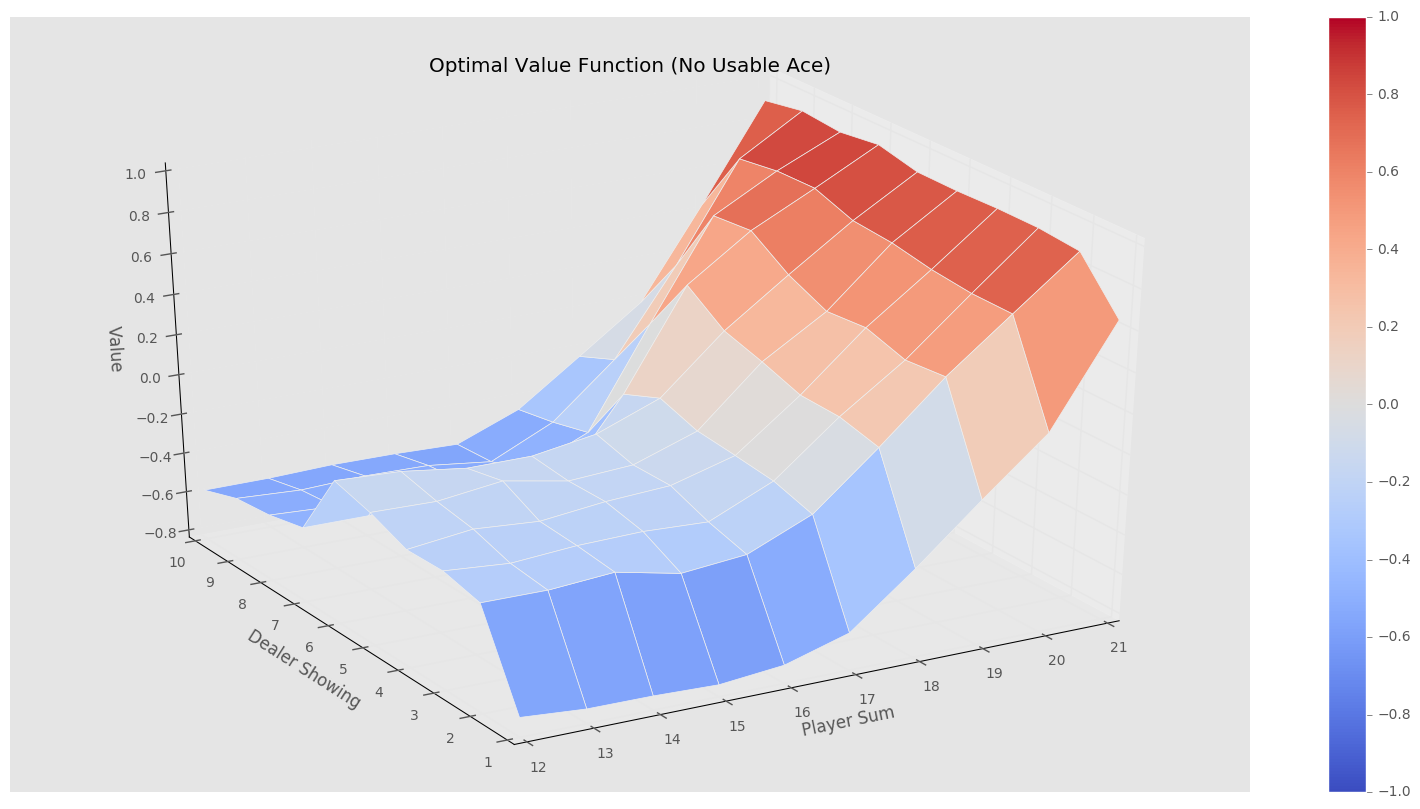

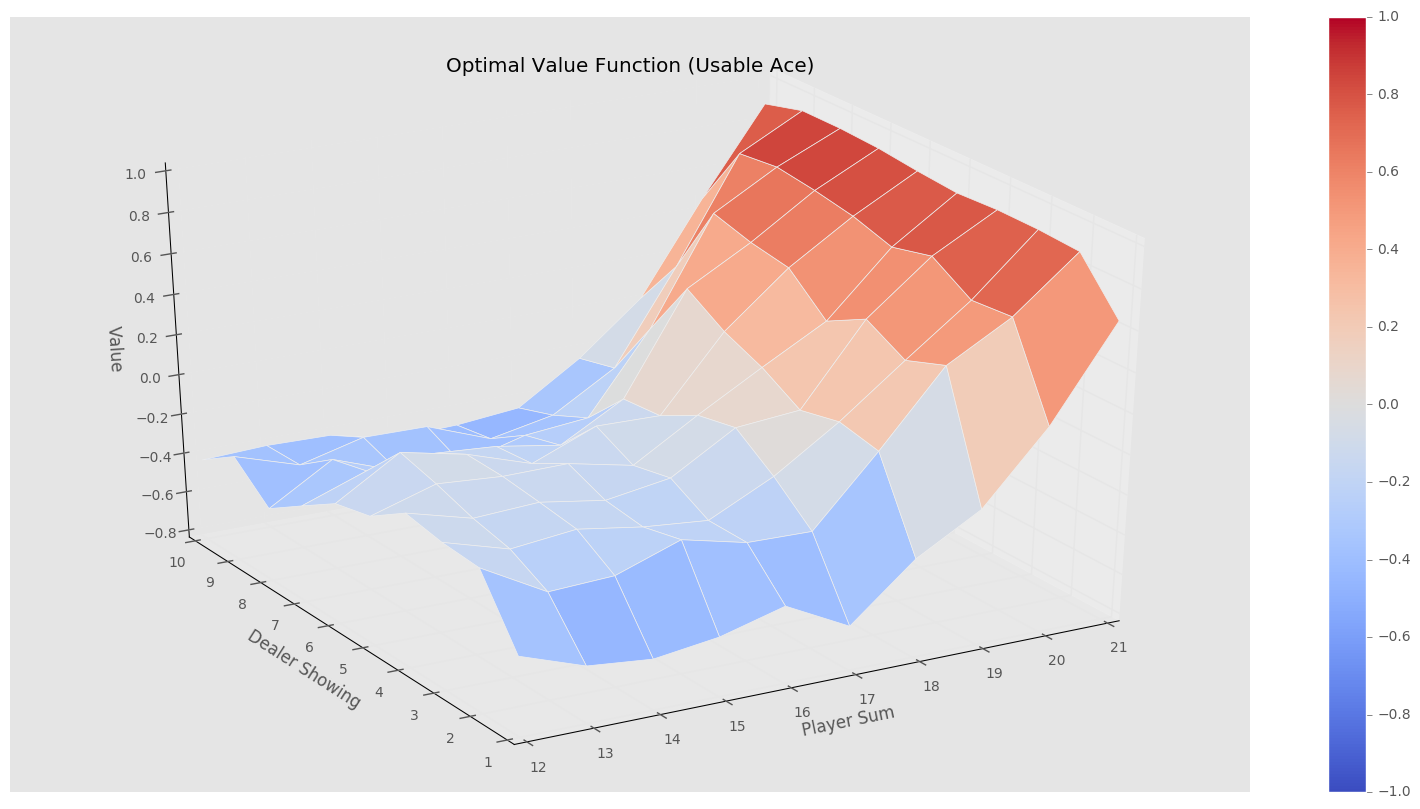

In [12]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")